In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time as time

# 1 - Number  of picked up travels per time zone

We create a Spark session. We select 7 cores for execute the codesnippet in parallel.

In [3]:
spark = SparkSession.builder\
      .master("local[7]")\
      .appName("Study2")\
      .getOrCreate()

First of all we have to get the data. In contrast with what we did on the serial version, now we use a moethod from spark to get both datasets directly into 1 object. Using spark we are direcly creating an RDD object. We will also start a count to measure the time. 

In [4]:
start = time.time()
spark_dataset = spark.read.option("header","true").option("inferSchema","true").csv("DATA/*.csv")

Then, we will transform the variable *tpep_pickup_datetime* into *datetime* format. Once we have that, we extract the hour and create a new column. Finally this new variable is transformed into categorical with 4 levels. 

In [5]:
data_sp = spark_dataset.withColumn("tpep_pickup_timestap",to_timestamp("tpep_pickup_datetime")) 
data_sp = data_sp.withColumn("tpep_pickup_hour", hour(to_timestamp("tpep_pickup_timestap","yyyy-MM-dd HH:mm:ss")))
data_sp = data_sp.withColumn("tpep_pickup_timezone", when((col("tpep_pickup_hour") >= 0) & (col("tpep_pickup_hour") < 6),"N")
                                 .when((col("tpep_pickup_hour") >= 6) & (col("tpep_pickup_hour") < 12),"M")
                                 .when((col("tpep_pickup_hour") >= 12) & (col("tpep_pickup_hour") < 18),"A")
                                 .when((col("tpep_pickup_hour") >= 18) & (col("tpep_pickup_hour") <= 24),"E")
                                 .when(col("tpep_pickup_hour").isNull() ,""))
                            
data_sp.groupBy('tpep_pickup_timezone').count().show()

+--------------------+------+
|tpep_pickup_timezone| count|
+--------------------+------+
|                   E|631164|
|                   M|473142|
|                   A|566760|
|                   N|271354|
+--------------------+------+



# 2 -  Average total price per trip excluding taxes

We select the columns corresponding to the amount of money excluding the taxes. 

In [12]:
no_taxes_rdd = spark_dataset.select(['fare_amount', 'tip_amount', 'tolls_amount', 'extra', 'improvement_surcharge'])

Since we want to compute the mean value, we need to compute the sum of all the elements of the object, the count of these elements and divide them. Let's start by computing and printing the number of observations present in the rdd object.

In [17]:
count = no_taxes_rdd.count()
print(count)

1942420


Secondly, we sum the elements of the rdd thanks to the function .reduce(), which allows us to make computations between the elements of the rdd object. 

In [14]:
rdd=spark.sparkContext.parallelize(no_taxes_rdd)
suma = no_taxes_rdd.reduce(lambda a,b : (a+b)).collect()
print(suma)

AttributeError: 'DataFrame' object has no attribute 'reduce'

Lastly, we divide them and obtain the mean value. 

In [ ]:
print(suma/count)

Of course, we can do the same thing for the 'mta_tax' value.

In [ ]:
taxes = spark_dataset.select(['mta_tax'])
count2 = taxes.count()
suma2 = taxes.reduce(lambda a,b : a+b)

mean = suma2/count2
print(mean)

We have obtained a mean value for the taxes amount close to 0.5$, as it was expected. 

# 3 - Type of payment in terms of different pick up zones

We are going to do the analysisis that we did before about the mean price of travels for the different pick-up zones and payment methods. The difference with the serial version that we have done in the other file is that for this case we will use some spark methods that allows parallel computation.

First we select the data and group them by location and type of payment while calculating the mean price for each group. To do this we simply use the groupBy() function that allows groupping spark objects.


In [ ]:
spark_dataset=spark_dataset.select(['DOLocationID','total_amount','payment_type'])
spark_dataset_groupped=spark_dataset.groupBy('DOLocationID','payment_type').avg('total_amount')

We want now to plot the information given in the analysis. However spark does not include any functions to compute plots in paralell so we will plot it using a DIY algorithm that uses matplotlib to do the plot.

No handles with labels found to put in legend.


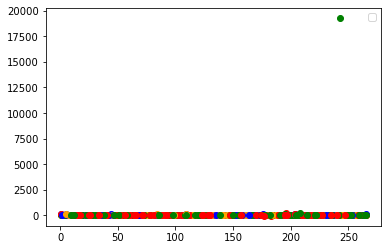

In [ ]:
to_plot=spark_dataset_groupped.collect()
for i in range(len(to_plot)):
    if(to_plot[i][1]==1):
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="blue")
    elif(to_plot[i][1]==2):
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="orange")
    elif(to_plot[i][1]==3):
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="green")
    else:
        plt.plot(to_plot[i][0],to_plot[i][2],marker='o',color="red")
plt.legend()
plt.show()

Again, as what happened in the serial version, we can see there is at least one observation that we do not want to consider so we will delete it for this analysis. Then we will plot the object returned by spark.

No handles with labels found to put in legend.


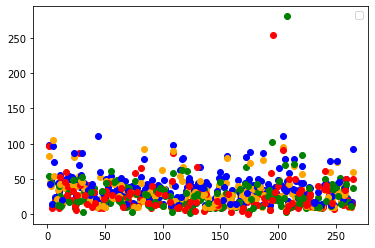

In [ ]:
spark_cleaned=spark_dataset.where(spark_dataset.total_amount<=1000)
spark_cleaned=spark_cleaned.where(spark_cleaned.total_amount>0)
spark_dataset_cleaned_groupped=spark_cleaned.groupBy('DOLocationID','payment_type').avg('total_amount')
to_plot_cleaned=spark_dataset_cleaned_groupped.collect()

for i in range(len(to_plot_cleaned)):
    if(to_plot_cleaned[i][1]==1):
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="blue")
    elif(to_plot_cleaned[i][1]==2):
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="orange")
    elif(to_plot_cleaned[i][1]==3):
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="green")
    else:
        plt.plot(to_plot_cleaned[i][0],to_plot_cleaned[i][2],marker='o',color="red")
plt.legend()
plt.show()

Finally we will also analyze the mean price paid in terms of each payment method and see its density plot. This time we will use the function groupByKey() that directly groups the data by a key and a value.

(0.0, 50.0)

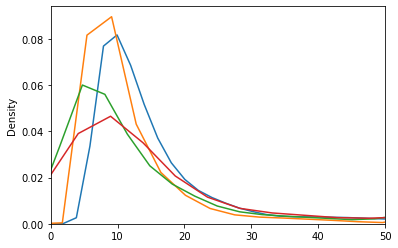

In [ ]:
density_plot=spark_cleaned.select(['payment_type','total_amount'])
density_groupped=density_plot.rdd
density_spark=density_groupped.groupByKey().collect()

for key, value in density_spark:
    if(key==1):
        x_1=list(value)
    elif(key==2):
        x_2=list(value)
    elif(key==3):
        x_3=list(value)
    else:
        x_4=list(value)

sns.kdeplot(x_1)
sns.kdeplot(x_2)
sns.kdeplot(x_3)
sns.kdeplot(x_4)
plt.xlim(0,50)




In [56]:
spark.stop()
stop=time.time()
print(stop-start)

144.2067608833313
